# 尝试优化HLS_FFT
---
## 准备数据

In [6]:
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import numpy as np

In [43]:
N = 16
fs = 1
T = 1.0/fs
x = np.linspace(0.0, N*T, N)
y = 0.7 * np.sin(2 * np.pi * 50.0 * x) + np.sin(2 * np.pi * 120.0 * x)
y = y + 2.0 * np.random.randn(N)
y = y * 1000;

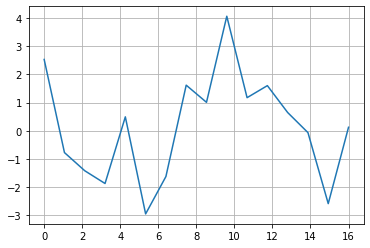

In [17]:
plt.plot(x, y)
plt.grid()
plt.show()

## 先看PS下python对FFT变换处理的速度

In [11]:
import time
start_time = time.time()

for i in range(1024):
    yf = fft(y)

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.08620166778564453s


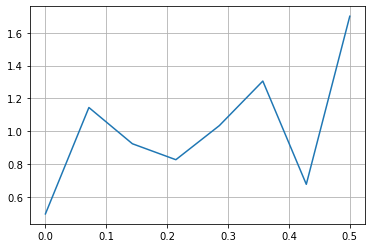

In [12]:
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, np.abs(yf[0:N//2])*2.0/N)
plt.grid()
plt.show()

## Xilinx_FFT_IP实现

In [33]:
from pynq import Overlay, allocate

overlay = Overlay("xilinx_fft_ip.bit")

dma = overlay.axi_dma_0

In [34]:
fft_length = y.shape[0]
print(fft_length)

4096


In [35]:
# allocate memory
input_buffer = allocate(shape=(fft_length,2), dtype='int16')
output_buffer = allocate(shape=(fft_length,2), dtype='int16')


In [36]:
input_buffer.shape

(4096, 2)

In [37]:
# input
y_int = np.int16(y)
np.copyto(input_buffer[:,0], y_int)

In [38]:
import time


start_time = time.time()

for i in range(1024):

    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait() # wait for send channel
    dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.7281391620635986s


In [44]:
yf = np.int64(output_buffer)
np.sqrt(np.square(yf[:,0],yf[:,0])+np.square(yf[:,1],yf[:,1]))*2.0/N
N//2

2048

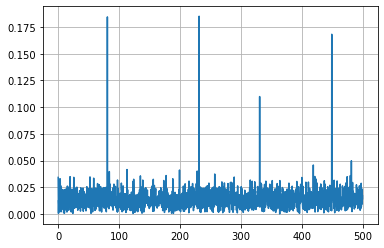

In [46]:
yf = np.int64(output_buffer)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, np.sqrt(np.square(yf[:N//2,0],yf[:N//2,0])+np.square(yf[:N//2,1],yf[:N//2,1]))*2.0/N)
plt.grid()
plt.show()

# 纯HLS_FFT实现

In [37]:
from pynq import Overlay, allocate

overlay = Overlay("my_fft.bit")

dma = overlay.axi_dma_0

In [38]:
myfft = overlay.testfft_0
myfft.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0)
}

In [48]:
fft_length = 16
input_buffer = allocate(shape=(fft_length,), dtype='float32')
output_buffer = allocate(shape=(fft_length,), dtype='float32')

In [49]:
y_float = np.float32(y)
np.copyto(input_buffer, y_float)

In [50]:
myfft.register_map.CTRL.AP_START = 1

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

In [51]:
output_buffer

PynqBuffer([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.], dtype=float32)